# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.parquet as pq

from typing import Union

# Load and process futures data

In [2]:
file_name = "./bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df_futures = table.to_pandas()
#
print(df_futures.shape)
df_futures.head()

(31951379, 11)


,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2022-10-01 00:00:00+00:00,1664582400000,5.406,5.406,5.401,5.403,20601.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:01:00+00:00,1664582460000,5.403,5.404,5.401,5.403,7417.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:02:00+00:00,1664582520000,5.403,5.407,5.403,5.407,4555.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:03:00+00:00,1664582580000,5.406,5.408,5.404,5.405,11194.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:04:00+00:00,1664582640000,5.404,5.406,5.404,5.405,1942.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10


In [3]:
# Drop unnecessary columns.
df_futures = df_futures[["close", "currency_pair"]]
# Drop currencies that are not present in RP.
df_futures = df_futures[~df_futures["currency_pair"].isin(["DYDX_USDT", "UNFI_USDT"])]
# Set currency pairs as index.
df_futures = df_futures.set_index("currency_pair", append=True)
# Sort the data.
df_futures = df_futures.sort_index(level=["currency_pair", "timestamp"])
df_futures

,,close
timestamp,currency_pair,
2022-03-17 15:00:00+00:00,APE_USDT,8.7750
2022-03-17 15:01:00+00:00,APE_USDT,8.8110
2022-03-17 15:02:00+00:00,APE_USDT,8.9130
2022-03-17 15:03:00+00:00,APE_USDT,8.9130
2022-03-17 15:04:00+00:00,APE_USDT,8.9520
...,...,...
2023-01-31 23:55:00+00:00,XRP_USDT,0.4062
2023-01-31 23:56:00+00:00,XRP_USDT,0.4057
2023-01-31 23:57:00+00:00,XRP_USDT,0.4059


## Compute returns

In [4]:
def get_returns(close_prices: pd.Series, periods: int, std_window: Union[str, int]) -> pd.Series:
    """
    Compute normalized log returns on minutely prices data.
    
    The returns are normalized by rolling standard deviation.
    
    :param close_prices: minutely prices data
    :param periods: the number of periods to shift to compute returns
        - 1: minutely returns
        - 1440: daily returns
    :param std_window: a time window to compute standard deviation
    :return: normalized log returns
    """
    # Compute log returns for a given time period.
    returns = np.log(close_prices/close_prices.shift(periods))
    # Compute the standard deviation in a rolling window.
    rolling_std = returns.rolling(std_window, on=close_prices.index.get_level_values("timestamp")).std()
    # Normalize the returns.
    returns_normalized = returns/rolling_std
    return returns_normalized

In [5]:
df_futures["returns"] = df_futures.groupby(level="currency_pair")["close"].transform(
    get_returns, periods=1440, std_window="3D"
)
df_futures

,,close,returns
timestamp,currency_pair,,
2022-03-17 15:00:00+00:00,APE_USDT,8.7750,NaN
2022-03-17 15:01:00+00:00,APE_USDT,8.8110,NaN
2022-03-17 15:02:00+00:00,APE_USDT,8.9130,NaN
2022-03-17 15:03:00+00:00,APE_USDT,8.9130,NaN
2022-03-17 15:04:00+00:00,APE_USDT,8.9520,NaN
...,...,...,...
2023-01-31 23:55:00+00:00,XRP_USDT,0.4062,1.166664
2023-01-31 23:56:00+00:00,XRP_USDT,0.4057,1.138444
2023-01-31 23:57:00+00:00,XRP_USDT,0.4059,1.176730


# Load and process RavenPack data

In [6]:
# Crypto coins from the target currency pairs.
coins_to_rp_entity_ids = {
    "APE": "F1E044",
    "AVAX": "E05E4B",
    "AXS": "27EA56",
    "BAKE": "A339AD",
    "BNB": "A2BF5C",
    "BTC": "A25816",
    "BUSD": "FCB6D2",
    "CRV": "0B364F",
    "CTK": "EED9D1",
    "DOGE": "2070E1",
    "DOT": "AA8895",
    # "DYDX" - missing from RP
    "ETH": "0A2CF4",
    "FTM": "ECE804",
    "GMT": "5687B4",
    "LINK": "E7792B",
    "MATIC": "AB69E3",
    "NEAR": "87A7FA",
    "OGN": "32B6C7",
    "RUNE": "BA701C",
    "SAND": "F85EC6",
    "SOL": "BF05E7",
    "STORJ": "49749C",
    # "UNFI" - missing from RP
    "USDT": "9D4B6F",
    "WAVES": "1E4A65",
    "XRP": "547BE3"
}

In [7]:
# Loading data for the target coins from 2019-09-01 to 2023-02-10.
rp_data = pd.read_csv("rp_crypto_data_2019_2023.csv")
print(rp_data.shape)
rp_data.head()

(339302, 30)


,TIMESTAMP_UTC,RP_DOCUMENT_ID,RP_ENTITY_ID,ENTITY_TYPE,ENTITY_NAME,ENTITY_RELEVANCE,ENTITY_SENTIMENT,ENTITY_SENTIMENT_CONFIDENCE,ENTITY_TEXT_SENTIMENT,ENTITY_TEXT_SENT_CONFIDENCE,...,EVENT_SIMILARITY_KEY,EVENT_SIMILARITY_DAYS,EVENT_TEXT,DOCUMENT_SENTIMENT,DOCUMENT_SENTIMENT_CONFIDENCE,COMPOSITE_SENTIMENT_SCORE,SENTIMENT_IMPACT_PROJECTION,RP_SOURCE_ID,SOURCE_NAME,RP_PROVIDER_ID
0,2019-09-01 00:00:05.121,32A54FBA6E174C02A820D46D70DE5D23,A25816,CURR,Bitcoin,95,0.35,0.89,0.34,0.89,...,F9273CEF3D017257E1656C7E90310BD8,33.73147,"Bitcoin topped $11,000 in late June",0.37,0.91,0.00,-0.08,A1F054,Winsight Grocery Business,DJTP
1,2019-09-01 02:06:04.236,5E9AA7A7F6143BEB5964B66354D8C94C,A25816,CURR,Bitcoin,99,-0.16,0.39,-0.13,0.34,...,9A23D7DBD282D06E9F2CCC6AE44F8A86,0.00789,Bitcoin price drops to $63,-0.02,0.01,-0.06,-0.02,E98DD9,Bitcoin Exchange Guide,MRVR
2,2019-09-01 04:14:01.905,F5EC63F223BF3FEE0971AE703A2B28AD,A25816,CURR,Bitcoin,89,0.01,0.03,0.00,0.01,...,6728D145C445266BD3A642C836146D69,365.00000,Bitcoin gained 0.24% on Saturday,-0.07,0.16,0.04,-0.16,09DF84,FXEmpire,MRVR
3,2019-09-01 04:14:01.905,F5EC63F223BF3FEE0971AE703A2B28AD,A25816,CURR,Bitcoin,89,0.01,0.03,0.00,0.01,...,1C1E77614153B8DDBFD78E16AE57ADD5,0.28857,Bitcoin down by 4.6% for August,-0.07,0.16,0.04,-0.16,09DF84,FXEmpire,MRVR
4,2019-09-01 04:38:57.256,CDC75DBD92BD69742E0A9167E5A5D643,A25816,CURR,Bitcoin,99,0.15,0.38,0.15,0.38,...,1E771C128EAF606A1915899F9762ADDC,0.71383,"Btc is priced at $9,651.64",-0.02,0.07,0.00,-0.50,371A09,OurBitcoinNews.com,MRVR


In [8]:
# Round up the timestamps to the next minute.
rp_data["timestamp"] = pd.to_datetime(rp_data["TIMESTAMP_UTC"]).apply(lambda x : x.ceil(freq="T"))
# Set timestamp as index.
rp_data = rp_data.set_index("timestamp")
# Set currency as index.
rp_data["currency"] = rp_data["RP_ENTITY_ID"].map({v: k for k, v in coins_to_rp_entity_ids.items()})
rp_data = rp_data.set_index("currency", append=True)
# Sort the data.
rp_data = rp_data.sort_index(level=["currency", "timestamp"])

In [9]:
[col for col in rp_data.columns if "SENT" in col]

['ENTITY_SENTIMENT',
 'ENTITY_SENTIMENT_CONFIDENCE',
 'ENTITY_TEXT_SENTIMENT',
 'ENTITY_TEXT_SENT_CONFIDENCE',
 'EVENT_SENTIMENT',
 'DOCUMENT_SENTIMENT',
 'DOCUMENT_SENTIMENT_CONFIDENCE',
 'COMPOSITE_SENTIMENT_SCORE',
 'SENTIMENT_IMPACT_PROJECTION']

In [10]:
# Set the sentiment type to use further.
sentiment_col = "EVENT_SENTIMENT"

In [11]:
# Drop unnecessary columns.
rp_data = rp_data[[sentiment_col, "EVENT_TEXT"]]
rp_data

EVENT_SENTIMENT  \
timestamp           currency                    
2022-06-22 05:38:00 APE                  -0.5   
2022-06-22 14:07:00 APE                  -0.5   
2022-06-22 18:47:00 APE                  -0.5   
2022-06-23 04:13:00 APE                  -0.5   
2022-06-23 04:37:00 APE                  -0.5   
...                                       ...   
2023-02-09 08:36:00 XRP                   0.0   
                    XRP                  -0.5   
2023-02-09 11:44:00 XRP                   0.0   
2023-02-09 14:47:00 XRP                   0.0   
2023-02-09 14:52:00 XRP                   0.0   

                                                                     EVENT_TEXT  
timestamp           currency                                                     
2022-06-22 05:38:00 APE       Apecoin, the Ethereum token of the Bored Ape Y...  
2022-06-22 14:07:00 APE                 Apecoin Falls More Than 10% In 24 hours  
2022-06-22 18:47:00 APE                 Apecoin Falls More Than 10% In 24 hours  
2022-06-23 04:13:00 APE       Apecoin Market Cap Sank More than $2.5 Billion...  
2022-06-23 04:37:00 APE       Apecoin Market Cap Sank More than $2.5 Billion...  
...                                                                         ...  
2023-02-09 08:36:00 XRP                                   XRP Price Prediction:  
                    XRP                              XRP's price fell victim to  
2023-02-09 11:44:00 XRP                          Ripple (XRP) Price Prediction;  
2023-02-09 14:47:00 XRP                          Ripple (XRP) Price Prediction:  
2023-02-09 14:52:00 XRP                          Ripple (XRP) Price Prediction:  

[339302 rows x 2 columns]

# Analyze support period

In [12]:
def get_stats(df: pd.DataFrame, groupby_level: str, values_col: str) -> None:
    """
    Get descriptive statistics for the given data.
    
    - the number of non-nan values
    - the start and the end of the data
    
    :param df: data to describe
    :param groupby_level: name of the index level used to group the data
    :param values_col: name of the column with the values to count
    """
    group_name = df.index.get_level_values(groupby_level)[0]
    start = df.index.get_level_values("timestamp").min()
    end = df.index.get_level_values("timestamp").max()
    num = df.count()[values_col]
    print(f"{group_name}: {num} non-nan values  || {start} --- {end}")

In [13]:
df_futures.groupby(level="currency_pair").apply(get_stats, "currency_pair", "returns")

APE_USDT: 459900 non-nan values  || 2022-03-17 15:00:00+00:00 --- 2023-01-31 23:59:00+00:00
AVAX_USDT: 1237980 non-nan values  || 2020-09-23 07:00:00+00:00 --- 2023-01-31 23:59:00+00:00
AXS_USDT: 1154456 non-nan values  || 2020-11-20 07:04:00+00:00 --- 2023-01-31 23:59:00+00:00
BAKE_USDT: 895260 non-nan values  || 2021-05-19 07:00:00+00:00 --- 2023-01-31 23:59:00+00:00
BNB_USDT: 1563359 non-nan values  || 2020-02-10 08:01:00+00:00 --- 2023-01-31 23:59:00+00:00
BTC_BUSD: 1078140 non-nan values  || 2021-01-12 07:00:00+00:00 --- 2023-01-31 23:59:00+00:00
BTC_USDT: 1785962 non-nan values  || 2019-09-08 17:57:00+00:00 --- 2023-01-31 23:59:00+00:00
CRV_USDT: 1269659 non-nan values  || 2020-09-01 07:01:00+00:00 --- 2023-01-31 23:59:00+00:00
CTK_USDT: 1155900 non-nan values  || 2020-11-19 07:00:00+00:00 --- 2023-01-31 23:59:00+00:00
DOGE_USDT: 1345860 non-nan values  || 2020-07-10 09:00:00+00:00 --- 2023-01-31 23:59:00+00:00
DOT_USDT: 1284060 non-nan values  || 2020-08-22 07:00:00+00:00 --- 20

""


In [14]:
rp_data.groupby(level="currency").apply(get_stats, "currency", sentiment_col)

APE: 513 non-nan values  || 2022-06-22 05:38:00 --- 2023-02-09 15:50:00
AVAX: 1176 non-nan values  || 2019-10-19 23:32:00 --- 2023-02-06 17:35:00
AXS: 1489 non-nan values  || 2020-11-19 15:53:00 --- 2023-01-31 10:19:00
BAKE: 127 non-nan values  || 2020-10-12 13:35:00 --- 2023-02-05 18:03:00
BNB: 2544 non-nan values  || 2019-09-01 06:10:00 --- 2023-02-09 14:05:00
BTC: 241948 non-nan values  || 2019-09-01 00:01:00 --- 2023-02-09 23:56:00
BUSD: 1609 non-nan values  || 2019-10-19 21:42:00 --- 2023-01-30 13:46:00
CRV: 268 non-nan values  || 2020-08-18 13:02:00 --- 2023-02-09 18:08:00
CTK: 18 non-nan values  || 2022-12-24 12:30:00 --- 2023-02-06 12:14:00
DOGE: 17598 non-nan values  || 2019-09-07 13:46:00 --- 2023-02-09 22:40:00
DOT: 984 non-nan values  || 2020-07-14 13:35:00 --- 2023-02-08 12:18:00
ETH: 47311 non-nan values  || 2019-09-01 12:29:00 --- 2023-02-09 23:52:00
FTM: 492 non-nan values  || 2019-09-12 15:45:00 --- 2023-02-07 16:54:00
GMT: 12 non-nan values  || 2022-12-02 12:25:00 ---

""


# Merge sentiment and futures data

In [15]:
# Drop duplicate sentiments (recorded in the same minute).
# Required for upsampling the data further.
n_prev = len(rp_data)
rp_data = rp_data[~rp_data.index.duplicated()]
print(f"Dropped {n_prev-len(rp_data)} duplicate values; current size: {len(rp_data)} values")

Dropped 91152 duplicate values; current size: 248150 values


In [16]:
# ExponentialSmoothing only works on the data without NaNs.
# If trained on data with "gaps", it cannot predict the prices to "fill in" these gaps.
def resample_ts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample sentiment data from sparse to minutely.
    
    The missing values are interpolated from the existing ones.
    
    :param df: original data
    :return: resampled data
    """
    df = df.reset_index("currency", drop=True)
    df = df.resample("T").interpolate(method="time")
    return df

rp_data = rp_data.groupby("currency").apply(resample_ts)
rp_data

EVENT_SENTIMENT  \
currency timestamp                              
APE      2022-06-22 05:38:00             -0.5   
         2022-06-22 05:39:00             -0.5   
         2022-06-22 05:40:00             -0.5   
         2022-06-22 05:41:00             -0.5   
         2022-06-22 05:42:00             -0.5   
...                                       ...   
XRP      2023-02-09 14:48:00              0.0   
         2023-02-09 14:49:00              0.0   
         2023-02-09 14:50:00              0.0   
         2023-02-09 14:51:00              0.0   
         2023-02-09 14:52:00              0.0   

                                                                     EVENT_TEXT  
currency timestamp                                                               
APE      2022-06-22 05:38:00  Apecoin, the Ethereum token of the Bored Ape Y...  
         2022-06-22 05:39:00                                                NaN  
         2022-06-22 05:40:00                                                NaN  
         2022-06-22 05:41:00                                                NaN  
         2022-06-22 05:42:00                                                NaN  
...                                                                         ...  
XRP      2023-02-09 14:48:00                                                NaN  
         2023-02-09 14:49:00                                                NaN  
         2023-02-09 14:50:00                                                NaN  
         2023-02-09 14:51:00                                                NaN  
         2023-02-09 14:52:00                     Ripple (XRP) Price Prediction:  

[33839311 rows x 2 columns]

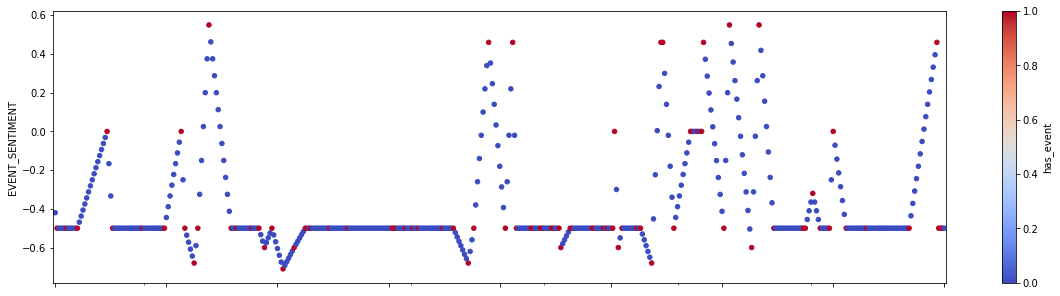

In [17]:
# View a slice of the data. 
# Red dots: actual events with the original sentiment.
# Blue dots: null events with the interpolated sentiment.
sent_slice = rp_data.loc["BTC"]["2022-06-22 04:00:00":"2022-06-22 12:00:00"]
sent_slice = sent_slice.reset_index("timestamp")
sent_slice["has_event"] = sent_slice["EVENT_TEXT"].apply(lambda x : int(type(x) == str))
sent_slice.plot(
    kind="scatter", x="timestamp", y=sentiment_col, 
    marker="o", c="has_event", colormap="coolwarm", 
    figsize=(20,5)
)
plt.xlim(pd.Timestamp("2022-06-22 03:59:00"),pd.Timestamp("2022-06-22 12:01:00"))
plt.show()

In [18]:
def add_sentiment_to_returns(returns: pd.Series) -> pd.Series:
    """
    Add sentiment data to returns.
    
    :param returns: returns data
    :return: data with added sentiment values
    """
    # Select RP data for the required currency and time period.
    curr = returns.index.get_level_values("currency_pair")[0].split("_")[0]
    rp_data_curr = rp_data.loc[curr][
        returns.index.get_level_values("timestamp").min(): returns.index.get_level_values("timestamp").max()
    ]
    # Match the RP data to the returns data; if for a given time point in returns
    # there is no sentiment, it will be added as NaN.
    rp_data_curr.index = rp_data_curr.index.tz_localize(tz="UTC")
    rp_data_curr = rp_data_curr.reindex(returns.index.get_level_values("timestamp"))
    rp_data_curr = rp_data_curr.set_index(returns.index.get_level_values("currency_pair"), append=True)
    sent_values = rp_data_curr[sentiment_col]
    return sent_values

df_futures["sentiment"] = df_futures.groupby("currency_pair")["returns"].transform(add_sentiment_to_returns)
df_futures = df_futures.dropna()
df_futures

/home/sonniki/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  # This is added back by InteractiveShellApp.init_path()


,,close,returns,sentiment
timestamp,currency_pair,,,
2022-06-22 05:38:00+00:00,APE_USDT,4.1810,-1.543122,-0.50
2022-06-22 05:39:00+00:00,APE_USDT,4.1740,-1.564692,-0.50
2022-06-22 05:40:00+00:00,APE_USDT,4.1730,-1.589089,-0.50
2022-06-22 05:41:00+00:00,APE_USDT,4.1660,-1.610566,-0.50
2022-06-22 05:42:00+00:00,APE_USDT,4.1650,-1.505315,-0.50
...,...,...,...,...
2023-01-31 23:55:00+00:00,XRP_USDT,0.4062,1.166664,-0.32
2023-01-31 23:56:00+00:00,XRP_USDT,0.4057,1.138444,-0.32
2023-01-31 23:57:00+00:00,XRP_USDT,0.4059,1.176730,-0.32


In [19]:
def remove_outliers(df: pd.DataFrame, window: Union[int, str], n_std: int) -> pd.DataFrame:
    """
    Remove outliers in returns.
    
    :param df: returns data
    :param window: size of the rolling window
    :param n_std: the number of standard deviations from the mean 
        to be considered an outlier
    :return: 
    """
    prev_n = len(df)
    group_name = df.index.get_level_values("currency_pair")[0]
    # Drop the outliers.
    df = df.reset_index("currency_pair", drop=True)
    mask = (
        np.abs(df["returns"] - df["returns"].rolling(window).mean()) <= 
        n_std * df["returns"].rolling(window).std()
    )
    df = df[mask].dropna()
    # Report.
    print(f"{group_name}: Dropped {prev_n-len(df)} outlier values; current size: {len(df)}")
    return df

df_futures = df_futures.groupby("currency_pair").apply(remove_outliers, window="3D", n_std=3)
df_futures

APE_USDT: Dropped 7698 outlier values; current size: 314525
AVAX_USDT: Dropped 23128 outlier values; current size: 1214852
AXS_USDT: Dropped 24395 outlier values; current size: 1129241
BAKE_USDT: Dropped 16363 outlier values; current size: 878897
BNB_USDT: Dropped 29156 outlier values; current size: 1534203
BTC_BUSD: Dropped 22752 outlier values; current size: 1055388
BTC_USDT: Dropped 39528 outlier values; current size: 1746434
CRV_USDT: Dropped 20637 outlier values; current size: 1249022
CTK_USDT: Dropped 636 outlier values; current size: 54774
DOGE_USDT: Dropped 29794 outlier values; current size: 1316066
DOT_USDT: Dropped 24462 outlier values; current size: 1259598
ETH_BUSD: Dropped 16078 outlier values; current size: 839071
ETH_USDT: Dropped 34856 outlier values; current size: 1636519
FTM_USDT: Dropped 22654 outlier values; current size: 1213886
GMT_USDT: Dropped 1547 outlier values; current size: 77324
LINK_USDT: Dropped 28777 outlier values; current size: 1568029
MATIC_USDT: Dro

close   returns  sentiment
currency_pair timestamp                                             
APE_USDT      2022-06-22 05:39:00+00:00  4.1740 -1.564692      -0.50
              2022-06-22 05:40:00+00:00  4.1730 -1.589089      -0.50
              2022-06-22 05:41:00+00:00  4.1660 -1.610566      -0.50
              2022-06-22 05:42:00+00:00  4.1650 -1.505315      -0.50
              2022-06-22 05:43:00+00:00  4.1590 -1.549124      -0.50
...                                         ...       ...        ...
XRP_USDT      2023-01-31 23:55:00+00:00  0.4062  1.166664      -0.32
              2023-01-31 23:56:00+00:00  0.4057  1.138444      -0.32
              2023-01-31 23:57:00+00:00  0.4059  1.176730      -0.32
              2023-01-31 23:58:00+00:00  0.4057  1.177007      -0.32
              2023-01-31 23:59:00+00:00  0.4056  1.196581      -0.32

[26527382 rows x 3 columns]

# Correlate sentiment and returns

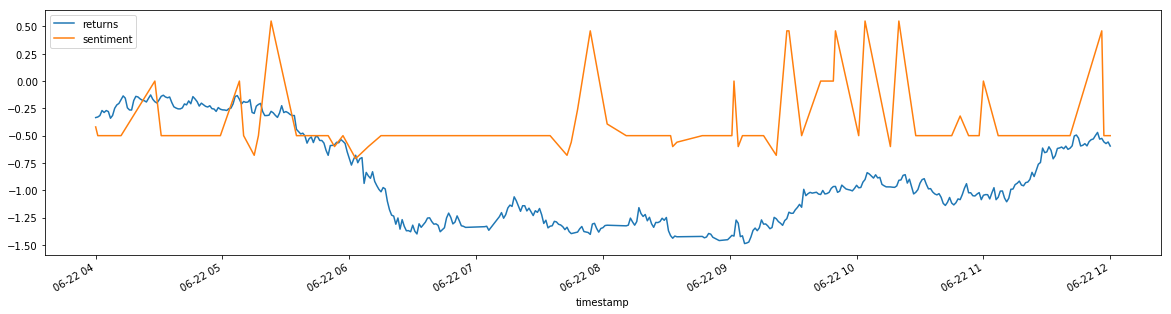

In [20]:
# View a slice of the data.
corr_slice = df_futures.loc["BTC_USDT"]["2022-06-22 04:00:00":"2022-06-22 12:00:00"]
corr_slice.plot(y=["returns", "sentiment"], figsize=(20,5))
plt.show()

In [21]:
def compute_correlation(df: pd.DataFrame, window: Union[str, int]) -> pd.DataFrame:
    """
    Compute Pearson correlation between returns and sentiment.
    
    :param df: original data
    :param window: size of the rolling window
    :return: data with added correlation
    """
    corr_coefs = df["sentiment"].rolling(window).corr(df["returns"])
    df = df.assign(corr = corr_coefs.values)
    return df

# Time offset doesn't seem to work with rolling correlation in pandas, so using integer.
# I had the same problem as described at the following links:
# https://stackoverflow.com/questions/42623154/rolling-correlation-not-working-with-offset-window 
# https://stackoverflow.com/questions/51202493/pandas-rolling-corr-using-date-time-offset
df_futures = df_futures.groupby("currency_pair").apply(compute_correlation, window=4320)
df_futures

close   returns  sentiment      corr
currency_pair timestamp                                                       
APE_USDT      2022-06-22 05:39:00+00:00  4.1740 -1.564692      -0.50       NaN
              2022-06-22 05:40:00+00:00  4.1730 -1.589089      -0.50       NaN
              2022-06-22 05:41:00+00:00  4.1660 -1.610566      -0.50       NaN
              2022-06-22 05:42:00+00:00  4.1650 -1.505315      -0.50       NaN
              2022-06-22 05:43:00+00:00  4.1590 -1.549124      -0.50       NaN
...                                         ...       ...        ...       ...
XRP_USDT      2023-01-31 23:55:00+00:00  0.4062  1.166664      -0.32 -0.553232
              2023-01-31 23:56:00+00:00  0.4057  1.138444      -0.32 -0.553322
              2023-01-31 23:57:00+00:00  0.4059  1.176730      -0.32 -0.553415
              2023-01-31 23:58:00+00:00  0.4057  1.177007      -0.32 -0.553508
              2023-01-31 23:59:00+00:00  0.4056  1.196581      -0.32 -0.553604

[26527382 rows x 4 columns]

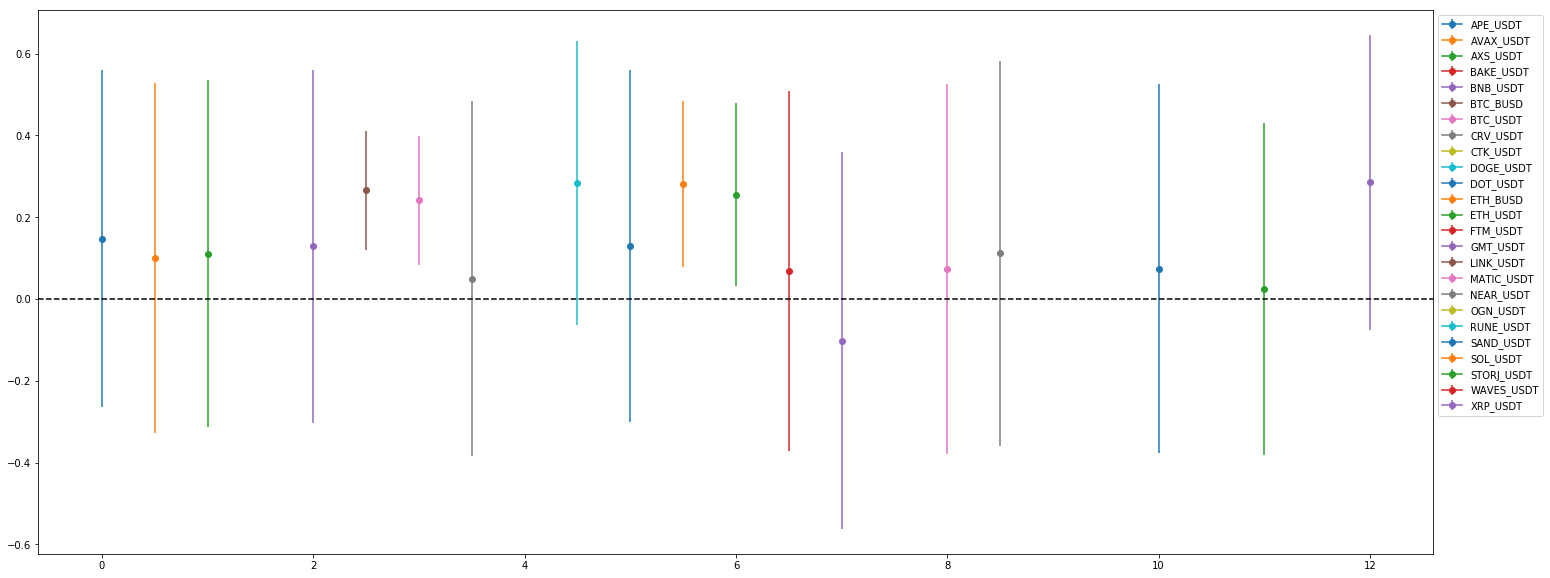

In [22]:
fix, ax = plt.subplots(figsize=(25,10))
n = 0
for curr_pair, df in df_futures.groupby(level="currency_pair"):
    mean = df["corr"].mean()
    std = df["corr"].std()
    ax.errorbar(n, mean, std, label=curr_pair, marker="o")
    n+=0.5
plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
plt.axhline(y=0.0, color="black", linestyle="--")
plt.plot()
plt.show()

# Compute PnL

In [23]:
def compute_pnl(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute PnL from returns and sentiment.
    
    :param df: original data
    :return: data with added PnL
    """
    pnl = (df["returns"].shift() * df["sentiment"]).cumsum()
    df = df.assign(pnl = pnl)
    return df

df_futures = df_futures.groupby("currency_pair").apply(compute_pnl)
df_futures

close   returns  sentiment  \
currency_pair timestamp                                                
APE_USDT      2022-06-22 05:39:00+00:00  4.1740 -1.564692      -0.50   
              2022-06-22 05:40:00+00:00  4.1730 -1.589089      -0.50   
              2022-06-22 05:41:00+00:00  4.1660 -1.610566      -0.50   
              2022-06-22 05:42:00+00:00  4.1650 -1.505315      -0.50   
              2022-06-22 05:43:00+00:00  4.1590 -1.549124      -0.50   
...                                         ...       ...        ...   
XRP_USDT      2023-01-31 23:55:00+00:00  0.4062  1.166664      -0.32   
              2023-01-31 23:56:00+00:00  0.4057  1.138444      -0.32   
              2023-01-31 23:57:00+00:00  0.4059  1.176730      -0.32   
              2023-01-31 23:58:00+00:00  0.4057  1.177007      -0.32   
              2023-01-31 23:59:00+00:00  0.4056  1.196581      -0.32   

                                             corr            pnl  
currency_pair timestamp                                           
APE_USDT      2022-06-22 05:39:00+00:00       NaN            NaN  
              2022-06-22 05:40:00+00:00       NaN       0.782346  
              2022-06-22 05:41:00+00:00       NaN       1.576891  
              2022-06-22 05:42:00+00:00       NaN       2.382174  
              2022-06-22 05:43:00+00:00       NaN       3.134831  
...                                           ...            ...  
XRP_USDT      2023-01-31 23:55:00+00:00 -0.553232  270724.005885  
              2023-01-31 23:56:00+00:00 -0.553322  270723.632552  
              2023-01-31 23:57:00+00:00 -0.553415  270723.268250  
              2023-01-31 23:58:00+00:00 -0.553508  270722.891697  
              2023-01-31 23:59:00+00:00 -0.553604  270722.515054  

[26527382 rows x 5 columns]

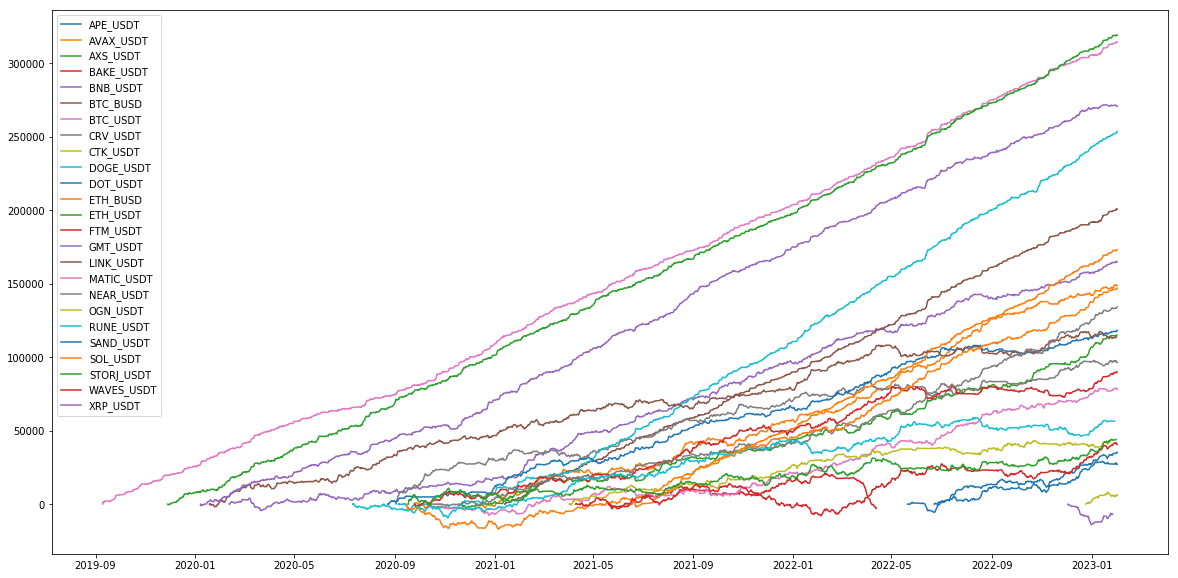

In [24]:
fix, ax = plt.subplots(figsize=(20,10))
for curr_pair, df in df_futures.groupby(level="currency_pair"):
    ax.plot(df.index.get_level_values("timestamp").values, df["pnl"].values, label=curr_pair)
plt.legend()
plt.plot()
plt.show()